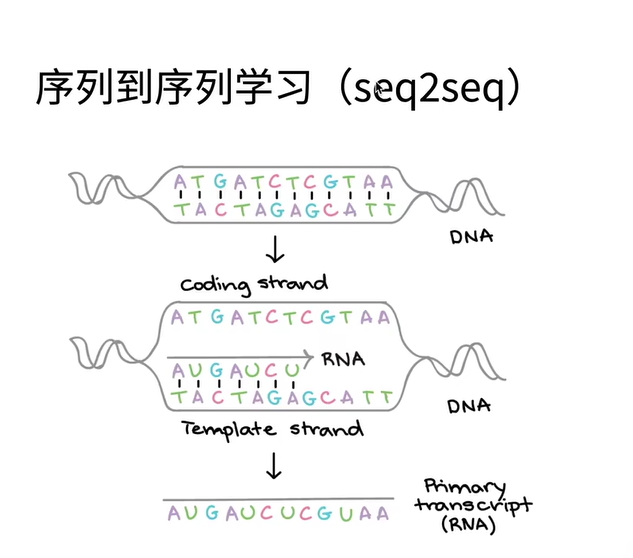

# S2S就是从一个句子到另一个句子

# 机器翻译就是一个S2S

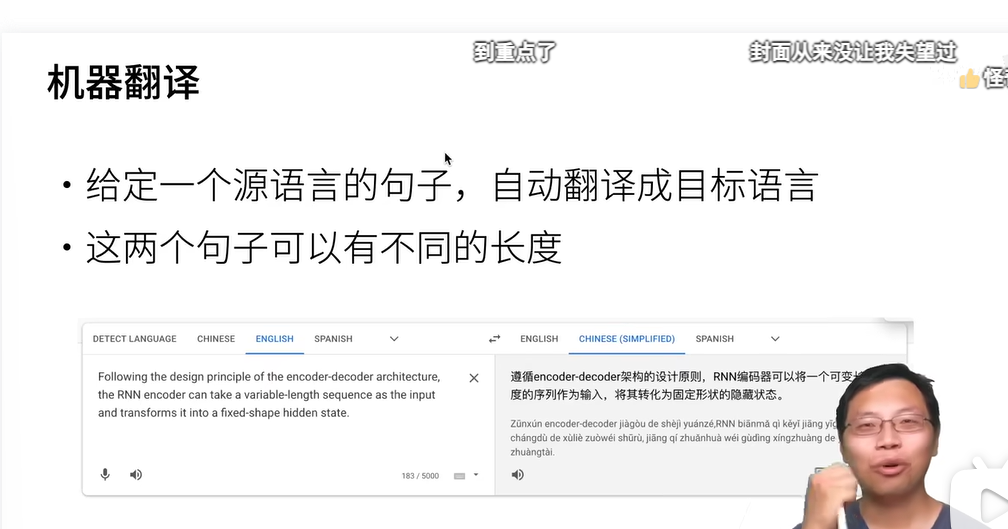

# 

# S2S的编码器（输入）和解码器（输出）

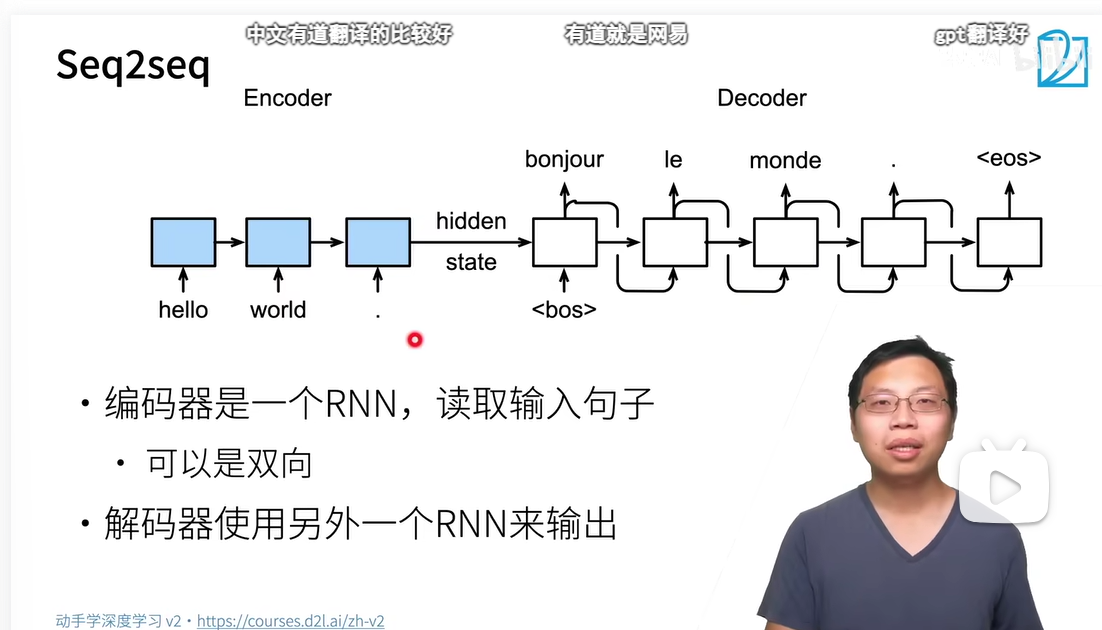

输入是一个句子用RNN（可以是双向RNN）
双向RNN一般用在编码器中

编码器最后的隐状态用作解码器的初始隐状态

# 训练和推理是不同的

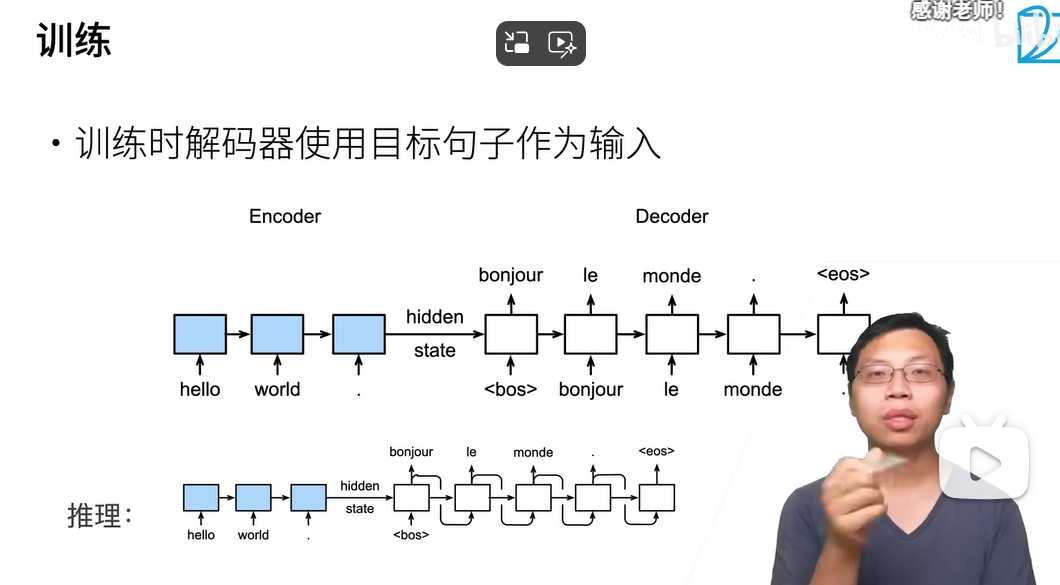

# 衡量生成序列的好坏的BLEU(1为最好 越低越差)

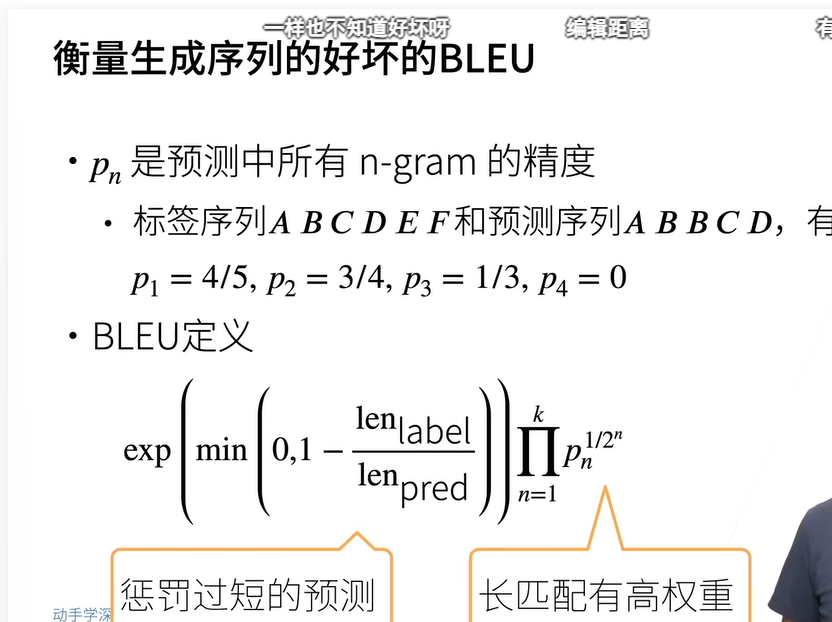

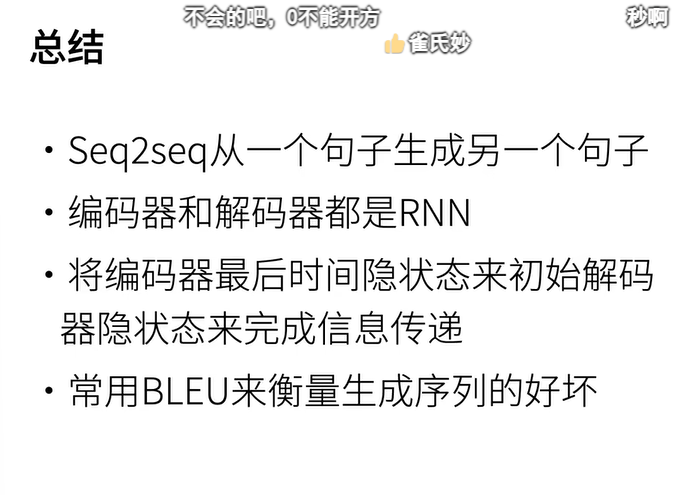

In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# @save 表示在 d2l 库中保存这段代码

#编码器的构建
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
#     继承自 d2l.Encoder，用于实现序列到序列（Seq2Seq）学习中的编码器部分
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        # 调用父类的构造函数进行初始化
#         vocab_size：词汇表的大小。
#         embed_size：词嵌入的维度。
#         num_hiddens：隐藏层的大小（循环神经网络的单元数）。
#         num_layers：循环神经网络的层数。
#         dropout：用于防止过拟合的 dropout 层的比率。
#         **kwargs：其他可选参数。
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        
        # 初始化嵌入层，将词汇表大小映射到嵌入维度
        self.embedding = nn.Embedding(vocab_size, embed_size)
#         创建一个 GRU（门控循环单元）层，输入维度为嵌入层的大小，
#         隐藏层维度为 num_hiddens，层数为 num_layers，并应用 dropout
        # 初始化循环神经网络，使用 GRU 作为基本单元
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        """前向传播函数
        X: 输入序列（词元索引）
        args: 其他可选参数
        """
        # 将输入 X 通过嵌入层，输出形状为 (batch_size, num_steps, embed_size)
        X = self.embedding(X)
        
        # 将序列的维度调整为 (num_steps, batch_size, embed_size)，方便 RNN 处理
        X = X.permute(1, 0, 2)
        
        # 将调整后的输入传入循环神经网络
#         将调整后的输入传入 GRU 层进行计算
        # output: GRU 的输出，形状为 (num_steps, batch_size, num_hiddens)
        # state: GRU 的最后状态，形状为 (num_layers, batch_size, num_hiddens)
        output, state = self.rnn(X)

        # 返回 RNN 的输出和最后的状态
        return output, state

In [3]:
# 创建一个 Seq2SeqEncoder 实例，其中:
# vocab_size=10: 词汇表的大小为 10
# embed_size=8: 嵌入维度为 8
# num_hiddens=16: 隐藏层的大小为 16
# num_layers=2: RNN 的层数为 2
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)

# 设置编码器为评估模式，防止在推理时使用 dropout 等
encoder.eval()

# 创建一个形状为 (4, 7) 的张量，
# 代表 4 个样本，每个样本有 7 个词元，词元的值为 0
X = torch.zeros((4, 7), dtype=torch.long)

# 将输入张量 X 传入 encoder，得到输出和隐藏状态
output, state = encoder(X)

# 打印输出张量的形状
output.shape

torch.Size([7, 4, 16])

In [4]:
# 所以在最后一个时间步的多层隐状态的形状是 
# （隐藏层的数量，批量大小，隐藏单元的数量）。 
# 如果使用长短期记忆网络，中还将包含记忆单元信息。state
state.shape

torch.Size([2, 4, 16])

In [5]:
# 解码器的构建
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
#         vocab_size：词汇表的大小。
#         embed_size：词嵌入的维度。
#         num_hiddens：隐藏层的大小（循环神经网络的单元数）。
#         num_layers：循环神经网络的层数。
#         dropout：用于防止过拟合的 dropout 层的比率。
#         **kwargs：其他可选参数。
        # 调用父类的构造函数进行初始化
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        
        # 初始化嵌入层，将词汇表大小映射到嵌入维度
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # 初始化循环神经网络（GRU），输入维度为 (嵌入维度 + 隐藏维度)，输出维度为隐藏维度
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        
        # 初始化全连接层，将 GRU 的输出映射到词汇表大小
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        """根据编码器的输出初始化解码器的状态"""
        return enc_outputs[1]  # 返回编码器的最后状态作为解码器的初始状态

    def forward(self, X, state):
        """前向传播函数
        X: 输入序列（词元索引）
        state: 解码器的状态
        """
        # 将输入 X 通过嵌入层，输出形状为 (batch_size, num_steps, embed_size)
        X = self.embedding(X).permute(1, 0, 2)  # 调整维度为 (num_steps, batch_size, embed_size)
        
        # 广播上下文向量，使其与 X 具有相同的 num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)  # state 的最后一个值作为上下文
        # 将输入 X 和上下文拼接，形成新的输入
        X_and_context = torch.cat((X, context), 2)  # 形成形状为 (num_steps, batch_size, embed_size + num_hiddens)
        
        # 将拼接后的输入传入 GRU，得到输出和新的状态
        output, state = self.rnn(X_and_context, state)  # 解码器的前向传播

        # 通过全连接层将 GRU 的输出映射到词汇表大小，并调整维度
        output = self.dense(output).permute(1, 0, 2)  # 将输出调整为 (batch_size, num_steps, vocab_size)

        # output的形状:(batch_size, num_steps, vocab_size)
        # state的形状:(num_layers, batch_size, num_hiddens)
        return output, state  # 返回解码器的输出和状态

In [6]:
# 创建一个 Seq2SeqDecoder 实例，其中:
# vocab_size=10: 词汇表的大小为 10
# embed_size=8: 嵌入维度为 8
# num_hiddens=16: 隐藏层的大小为 16
# num_layers=2: RNN 的层数为 2
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)

# 设置解码器为评估模式，防止在推理时使用 dropout 等
decoder.eval()

# 初始化解码器的状态，将编码器的输出传入 init_state 方法
# encoder(X) 表示之前对输入 X 所做的编码，通常用于获取编码器的输出
state = decoder.init_state(encoder(X))

# 将输入张量 X 和解码器的状态传入解码器，以获得解码器的输出
output, state = decoder(X, state)

# 获取输出和状态的形状
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

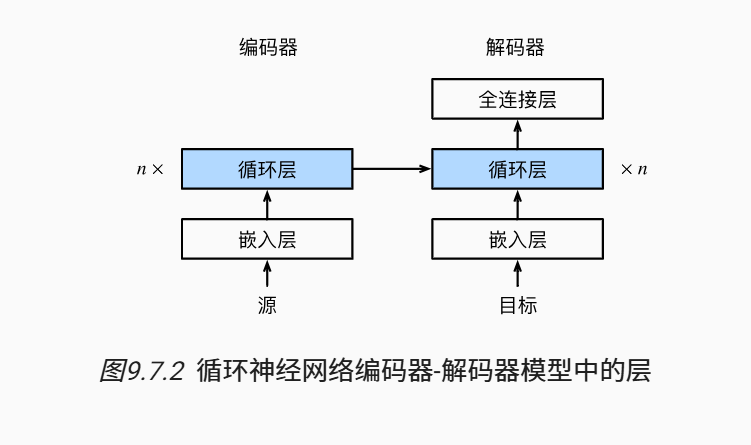

In [7]:
# @save 表示在 d2l 库中保存这段代码


#通过零值化屏蔽不相关的项

def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项
    参数:
    X: 输入张量，通常是批量中的多个序列
    valid_len: 一个张量，表示每个序列的有效长度
    value: 要用来填充被屏蔽元素的值，默认是 0
    """
    # 获取输入 X 中序列的最大长度
    maxlen = X.size(1)
    
    # 创建一个布尔掩码，掩码的形状为 (batch_size, maxlen)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    
    # 将掩码中为 False 的位置替换为指定的值
    X[~mask] = value
    
    # 返回屏蔽后的张量
    return X

# 创建一个示例张量 X，表示两个序列
X = torch.tensor([[1, 2, 3], [4, 5, 6]])

# 调用 sequence_mask 函数，对输入 X 应用有效长度的掩码
# 这里有效长度的张量为 [1, 2]，表示第一个序列的有效长度为 1，第二个序列的有效长度为 2
sequence_mask(X, torch.tensor([1, 2]))

# masked_X 的输出为：
# [[1, 0, 0],
#  [4, 5, 0]]

tensor([[1, 0, 0],
        [4, 5, 0]])

In [8]:
# 通过softmax交叉熵损失函数来屏蔽不相关的预测
# 用于实现带遮蔽的交叉熵损失函数。
# @save 表示在 d2l 库中保存这段代码
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    
    # pred的形状：(batch_size, num_steps, vocab_size)
    # label的形状：(batch_size, num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        """计算带遮蔽的交叉熵损失"""
        
        # 创建一个与 label 相同形状的权重张量，初始值为 1
        weights = torch.ones_like(label)
        
        # 使用 sequence_mask 函数，对 weights 进行遮蔽处理
        weights = sequence_mask(weights, valid_len)
        
        # 将损失的减少方式设置为 'none'，意味着不会对损失进行聚合
        self.reduction = 'none'
        
        # 计算未加权的交叉熵损失，将预测值的维度调整为 (batch_size, vocab_size, num_steps)
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)  # permute 用来调整 pred 的维度顺序
        
        # 将未加权损失乘以权重，并对每个序列的损失进行平均
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        
        return weighted_loss  # 返回加权后的损失

In [9]:
# 创建 MaskedSoftmaxCELoss 的实例
loss = MaskedSoftmaxCELoss()

# 计算带有遮蔽的交叉熵损失
# pred: 模型的输出，形状为 (3, 4, 10)，其中 3 是批量大小，4 是时间步数，10 是词汇表大小
# label: 实际标签，形状为 (3, 4)，其中 3 是批量大小，4 是时间步数
# valid_len: 一个张量，表示每个序列的有效长度，这里 [4, 2, 0] 表示：
#   - 第一个序列有效长度为 4
#   - 第二个序列有效长度为 2
#   - 第三个序列有效长度为 0（全部被遮蔽）
loss(torch.ones(3, 4, 10), 
torch.ones((3, 4), dtype=torch.long), 
                  torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [10]:
# @save 表示在 d2l 库中保存这段代码
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    
    def xavier_init_weights(m):
        """初始化权重的辅助函数，使用 Xavier 初始化方法"""
        if type(m) == nn.Linear:  # 如果该层是线性层
            nn.init.xavier_uniform_(m.weight)  # 使用 Xavier 均匀分布初始化权重
        if type(m) == nn.GRU:  # 如果该层是 GRU
            for param in m._flat_weights_names:  # 遍历 GRU 的所有权重名称
                if "weight" in param:  # 只对权重进行初始化
                    nn.init.xavier_uniform_(m._parameters[param])  # 使用 Xavier 均匀分布初始化权重

    # 应用权重初始化
    net.apply(xavier_init_weights)
    
    # 将模型移动到指定设备（CPU 或 GPU）
    net.to(device)
    
    # 使用 Adam 优化器
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    # 实例化带遮蔽的交叉熵损失函数
    loss = MaskedSoftmaxCELoss()
    
    # 设置模型为训练模式
    net.train()
    
    # 创建一个动画器，用于可视化训练损失
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    
    # 开始训练循环
    for epoch in range(num_epochs):
        timer = d2l.Timer()  # 创建一个计时器，以跟踪训练时间
        metric = d2l.Accumulator(2)  # 初始化累加器，用于保存训练损失总和和词元数量
        
        # 遍历数据批次
        for batch in data_iter:
            optimizer.zero_grad()  # 清零梯度
            
            # 将数据移动到指定设备
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            
            # 创建批量大小个 <bos> 向量，作为解码器输入的开始标记
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学，即将 <bos> 送入解码器以及真实标签的前 n-1 项
            
            # 进行前向传播
            Y_hat, _ = net(X, dec_input, X_valid_len)
            
            # 计算损失
            l = loss(Y_hat, Y, Y_valid_len)
            
            # 损失函数的标量进行反向传播
            l.sum().backward()
            
            # 梯度裁剪，避免梯度爆炸
            d2l.grad_clipping(net, 1)
            
            # 计算有效词元的数量
            num_tokens = Y_valid_len.sum()
            
            # 更新模型参数
            optimizer.step()
            
            # 在不需要计算梯度的情况下，更新累加器
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)  # 累加当前批次的损失和有效词元数量
        
        # 每 10 个 epoch 打印一次训练损失
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    
    # 打印最终损失和每秒处理的令牌数量
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.019, 28597.4 tokens/sec on cuda:0


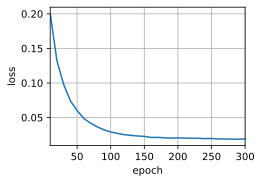

In [11]:
# 定义超参数
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1  # 嵌入维度、隐藏层维度、RNN 层数、dropout 比率
batch_size, num_steps = 64, 10  # 每批次样本数量和时间步数
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()  # 学习率、训练轮数和设备设置

# 加载数据集，返回数据迭代器、源语言词汇表和目标语言词汇表
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

# 创建编码器，传入词汇表大小、嵌入维度、隐藏层维度、层数和 dropout
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)

# 创建解码器，传入词汇表大小、嵌入维度、隐藏层维度、层数和 dropout
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

# 创建编码器-解码器模型，将编码器和解码器组合在一起
net = d2l.EncoderDecoder(encoder, decoder)

# 训练序列到序列模型
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

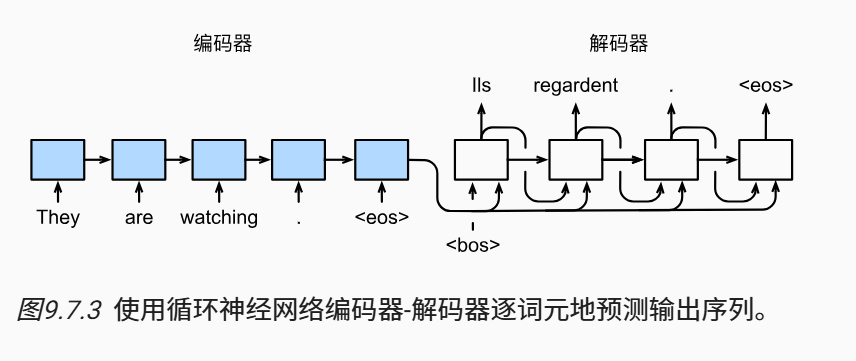

In [12]:
# @save 表示在 d2l 库中保存这段代码
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测
    参数:
    net: 训练好的序列到序列模型
    src_sentence: 源句子，字符串形式
    src_vocab: 源语言的词汇表
    tgt_vocab: 目标语言的词汇表
    num_steps: 最大解码时间步
    device: 计算设备（CPU 或 GPU）
    save_attention_weights: 是否保存注意力权重
    """
    # 在预测时将模型设置为评估模式
    net.eval()
    
    # 将源句子分词并转换为对应的词汇表索引，添加结束符
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    
    # 计算有效长度的张量
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    
    # 对源句子进行填充或截断，使之符合 num_steps 的长度
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    
    # 将源句子的索引添加一个批量维度
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    
    # 使用编码器对输入进行编码，得到编码器的输出
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    
    # 初始化解码器的状态
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    
    # 设置解码器的输入为目标语言的开始符
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    
    # 存储输出序列和注意力权重
    output_seq, attention_weight_seq = [], []
    
    # 在给定的时间步数内进行预测
    for _ in range(num_steps):
        # 通过解码器生成下一个词元及更新解码器状态
        Y, dec_state = net.decoder(dec_X, dec_state)
        
        # 选择具有最高概率的词元作为下一个输入
        dec_X = Y.argmax(dim=2)
        
        # 获取当前预测的词元，并转换为 Python 整数
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        
        # 如果需要，保存当前的注意力权重
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        
        # 如果预测到结束符，则输出序列生成完成
        if pred == tgt_vocab['<eos>']:
            break
        
        # 将预测的词元添加到输出序列
        output_seq.append(pred)
    
    # 将输出序列转换为目标语言的字符串表示
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [13]:
# BLEU的代码实现

def bleu(pred_seq, label_seq, k):  # @save
    """计算BLEU分数
    参数:
    pred_seq: 预测的序列（字符串形式）
    label_seq: 真实标签（字符串形式）
    k: n-gram的最大值
    返回:
    score: 计算得到的BLEU分数
    """
    
    # 将预测序列和标签序列分词，并计算它们的长度
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    
    # 计算惩罚因子，防止预测序列长度小于真实标签序列长度
    score = math.exp(min(0, 1 - len_label / len_pred))
    
    # 遍历从1到k的每个n，计算n-gram的匹配
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)  # 初始化匹配计数和标签子串字典
        
        # 收集标签中的n-gram
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        
        # 检查预测中的n-gram是否在标签中
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1  # 有匹配则增加计数
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1  # 减少该n-gram的计数（避免重复计算）
        
        # 更新BLEU分数
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    
    return score  # 返回计算出的BLEU分数

In [14]:

# 利用训练好的循环神经网络“编码器－解码器”模型， 
# 将几个英语句子翻译成法语，并计算BLEU的最终结果

engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va au lit !, bleu 0.000
i lost . => j'ai perdu perdu perdu perdu ., bleu 0.562
he's calm . => il est riche est venu venu recul venu recul recul, bleu 0.258
i'm home . => je suis calme ., bleu 0.512
